In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import utils

In [3]:
np.random.seed(1)
tf.set_random_seed(1)

In [4]:
mnist = input_data.read_data_sets('data/', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
n_crops = np.random.randint(1, 5)
n_crops

2

(array([9, 9]), array([[108, 156, 124, 190],
        [157, 130, 190, 163]]))

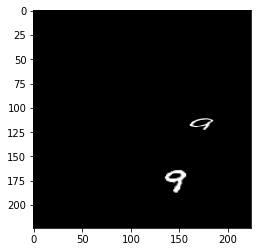

In [6]:
# use [y1, x1, y2, x2] as per original R-CNN trilogy
def make_crop(image):
    scale = np.random.uniform(0.5, 1.5, size=[2])
    w, h = (scale * 28).astype(np.int64)
    x = np.random.randint(image.shape[1] - w)
    y = np.random.randint(image.shape[0] - h)
    return y, x, y+h, x+w

def add_crop(image):
    crop, label = mnist.train.next_batch(1)
    crop = crop.reshape([28, 28])

    y1, x1, y2, x2 = make_crop(image)
    crop = cv2.resize(crop, (x2-x1, y2-y1))

    image[y1:y2, x1:x2] = crop
    return int(label), [y1, x1, y2, x2]

image = np.zeros([224, 224], np.float32)
gt_cls, gt_boxes = zip(*[add_crop(image) for i in range(n_crops)])
gt_cls, gt_boxes = map(np.array, (gt_cls, gt_boxes))

plt.imshow(image, cmap='gray')
gt_cls, gt_boxes

In [7]:
scales = [8, 16, 32, 64]
ratios = [0.5, 1.0, 2.0]
backbone_shapes = np.array([
    [56, 56],
    [28, 28],
    [14, 14],
    [7, 7],
])
strides = [4, 8, 16, 32]
anchors_per_cell = len(ratios)

In [8]:
anchors = [utils.generate_anchors(scales, ratios, shape, stride, 1)
           for scale, shape, stride in zip(scales, backbone_shapes, strides)]
anchors_per_level = [len(l) for l in anchors]
anchors = np.concatenate(anchors, axis=0)
anchors_per_level, sum(anchors_per_level)

([37632, 9408, 2352, 588], 49980)

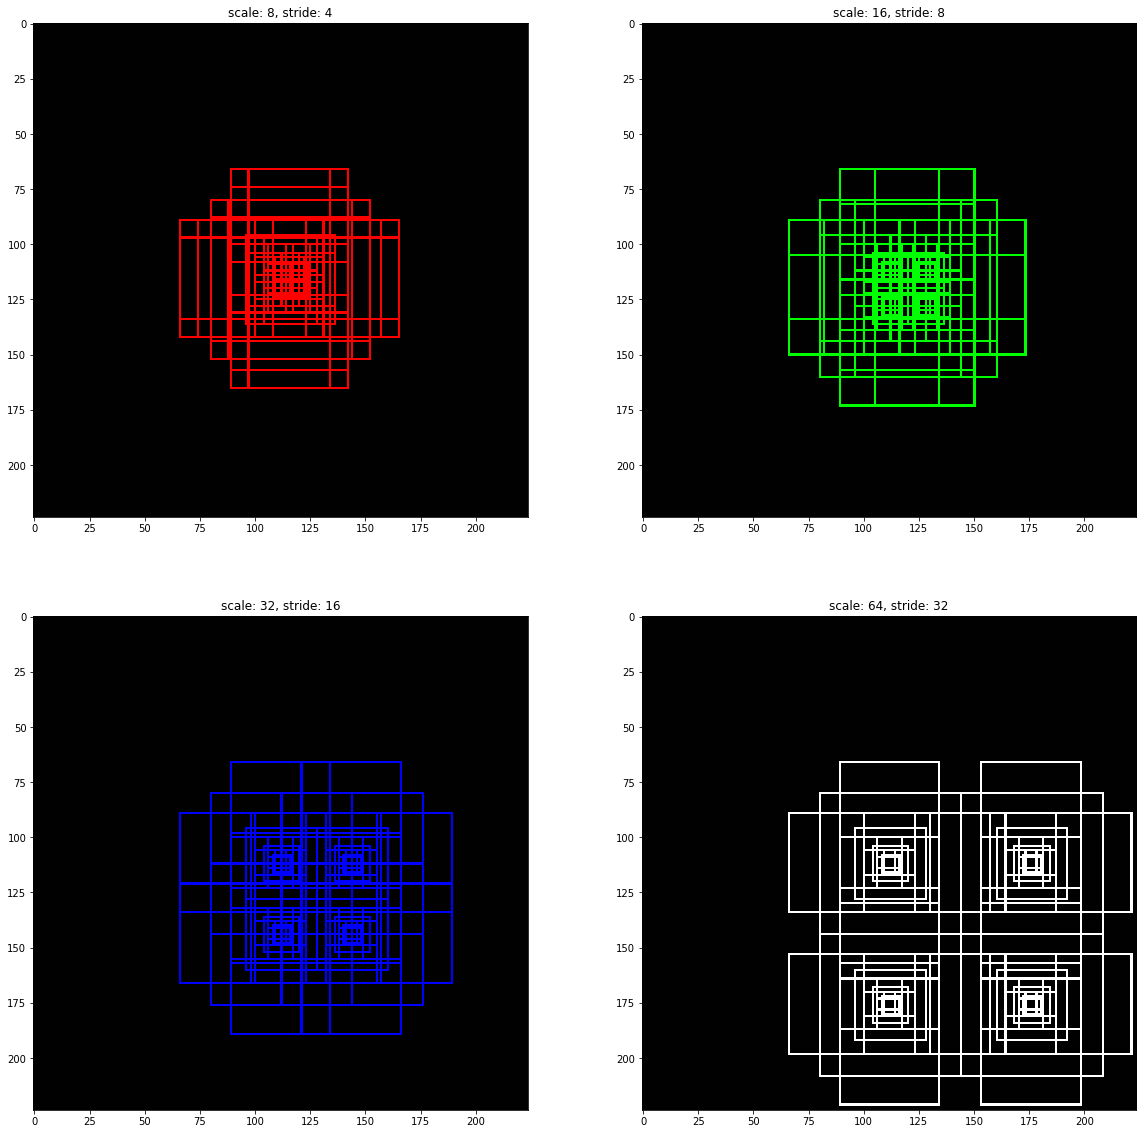

In [9]:
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255)]

plt.figure(figsize=(20, 20))
for i in range(len(colors)):
    scale, shape, stride, color = scales[i], backbone_shapes[i], strides[i], colors[i]
    tmp_image = np.ones([224, 224, 3], np.uint8)
    tmp_anchors = utils.generate_anchors(scales, ratios, [3, 3], stride, 2)
    for anchor in tmp_anchors:
        y1, x1, y2, x2 = (anchor + 112).astype(np.int64).tolist()
        cv2.rectangle(tmp_image, (x1, y1), (x2, y2), color, 1)
    plt.subplot(2, 2, i+1)
    plt.title(f'scale: {scale}, stride: {stride}')
    plt.imshow(tmp_image)
plt.show()

In [10]:
def iou(box, boxes):
    """
    Calculates the IoU of the ground truth box against an array of given boxes.
    
    Parameters:
        box: Ground truth box, 1-D vector of [y1, x1, y2, x2]
        boxes: Array of boxes, [-1, [y1, x1, y2, x2]]
    """
    box_area = (box[3] - box[1]) * (box[2] - box[0])
    boxes_area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    return intersection / union

In [11]:
ious = np.stack([iou(gt_box, anchors) for gt_box in gt_boxes])
ious.shape

(2, 49980)

In [12]:
max_iou_per_gt_box = np.argmax(ious, axis=1)
max_iou_per_anchor = np.where(np.max(ious, axis=0) > 0.7)[0]
max_iou_per_gt_box, max_iou_per_anchor

(array([20002, 29346]), array([29334, 29346, 30006, 30018, 45246, 49002]))

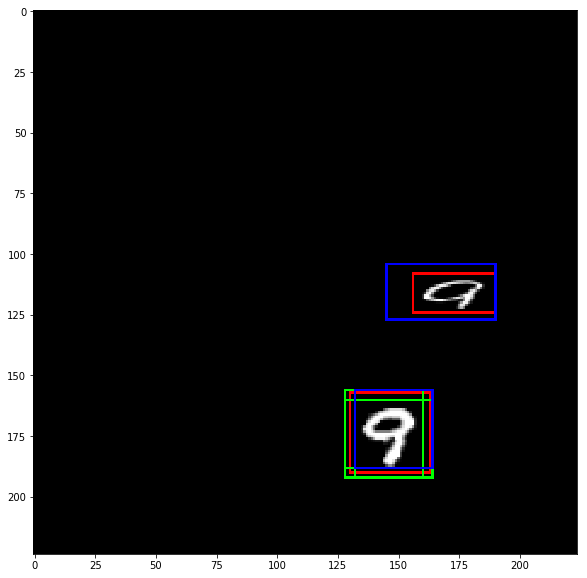

In [13]:
tmp = cv2.merge([(image * 255).astype(np.uint8)] * 3)
for y1, x1, y2, x2 in gt_boxes:
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (255, 0, 0), 1)
for anchor in anchors[max_iou_per_anchor]:
    y1, x1, y2, x2 = anchor.astype(np.int64).tolist()
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (0, 255, 0), 1)
for anchor in anchors[max_iou_per_gt_box]:
    y1, x1, y2, x2 = anchor.astype(np.int64).tolist()
    cv2.rectangle(tmp, (x1, y1), (x2, y2), (0, 0, 255), 1)
plt.figure(figsize=(10, 10))
plt.imshow(tmp);